In [9]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm  # Optional for progress bar

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_path = "/home/bartek/Kod/PD/praca_dyplomowa/dane/modele/vit_code_classifier_full.pt"

In [11]:
def load_model(path="vit_code_classifier_full.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(path, map_location=device)
    model.eval()  # Set to evaluation mode
    return model, device

In [8]:
def find_images(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [13]:
# Predict on a directory with nested folders
def predict_directory(model_path, directory):
    # Load model
    model, device = load_model(model_path)
    feature_extractor = model.feature_extractor if hasattr(model, 'feature_extractor') else None
    
    # Find all images
    image_paths = find_images(directory)
    print(f"Found {len(image_paths)} images")
    
    # Process each image
    results = []
    for img_path in tqdm(image_paths):
        try:
            # Load and preprocess image
            img = Image.open(img_path).convert("RGB")
            
            # If we have the feature extractor in the model
            if feature_extractor:
                inputs = feature_extractor(images=[img], return_tensors="pt")
            else:
                # If not, we need to use the transformers library feature extractor
                from transformers import ViTFeatureExtractor
                fe = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
                inputs = fe(images=[img], return_tensors="pt")
                
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Run inference
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                prediction = torch.argmax(probs, dim=1).item()
                confidence = probs[0][prediction].item()
            
            label = "Code" if prediction == 1 else "Not Code"
            results.append((img_path, label, confidence))
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append((img_path, "Error", 0.0))
    
    # Count predictions
    code_count = sum(1 for _, label, _ in results if label == "Code")
    not_code_count = sum(1 for _, label, _ in results if label == "Not Code")
    error_count = sum(1 for _, label, _ in results if label == "Error")
    
    print(f"\nResults Summary:")
    print(f"Code: {code_count}")
    print(f"Not Code: {not_code_count}")
    print(f"Errors: {error_count}")
    
    return results

In [14]:
test_directory = "/home/bartek/Kod/PD/praca_dyplomowa/images"
results = predict_directory(model_path, test_directory)

/tmp/ipykernel_102837/1637059450.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


Found 1254 images


  0%|          | 0/1254 [00:00<?, ?it/s]/home/bartek/Kod/PD/pd_env/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
  2%|▏         | 29/1254 [00:04<03:26,  5.94it/s]/home/bartek/Kod/PD/pd_env/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 85/1254 [00:13<02:37,  7.41it/s]

Error processing /home/bartek/Kod/PD/praca_dyplomowa/images/Analysing_ISFB_–_The_First_Loader/check_arch.png: image file is truncated


100%|██████████| 1254/1254 [03:24<00:00,  6.12it/s]


Results Summary:
Code: 246
Not Code: 1007
Errors: 1


In [17]:
from PIL import Image
import base64
from io import BytesIO
from IPython.display import HTML, display
import os

In [18]:
def display_results(results, cols=3, size=(150, 150)):
    """
    Simple display of prediction results in a grid.
    
    Args:
        results: List of tuples (img_path, label, confidence)
        cols: Number of columns
        size: Thumbnail size
    """
    html = "<div style='display: grid; grid-template-columns: repeat(" + str(cols) + ", 1fr); gap: 10px;'>"
    
    for img_path, label, confidence in results:
        try:
            # Load and resize image
            img = Image.open(img_path).convert('RGB')
            img.thumbnail(size)
            
            # Convert to base64
            buffer = BytesIO()
            img.save(buffer, format="JPEG")
            img_str = base64.b64encode(buffer.getvalue()).decode()
            
            # Get filename
            filename = os.path.basename(img_path)
            
            # Add to grid
            html += f"""
            <div style='border: 1px solid #ddd; padding: 10px; text-align: center;'>
                <img src='data:image/jpeg;base64,{img_str}' style='max-width: 100%;'>
                <div><b>{label}</b> ({confidence:.2f})</div>
                <div style='font-size: 10px; overflow: hidden;'>{filename}</div>
            </div>
            """
        except Exception as e:
            print(f"Error with {img_path}: {e}")
    
    html += "</div>"
    display(HTML(html))

# Example usage:
# display_results(results, cols=4)

In [25]:
results_code = [res for res in results if res[1]=="Code"]

In [26]:
results_not_code = [res for res in results if res[1]=="Not Code"]


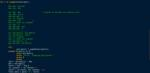
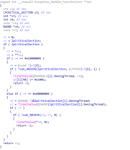
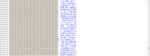
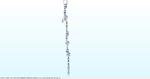
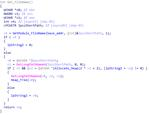
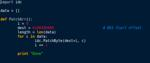
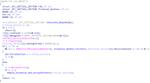
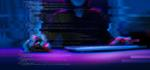
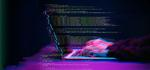
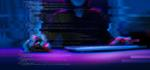
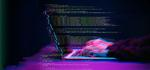
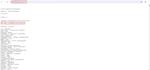
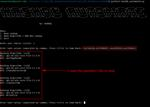
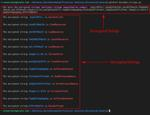
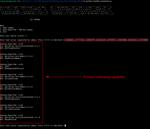
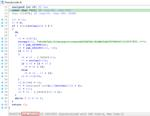
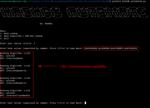
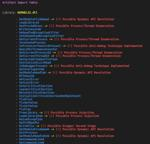
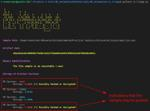
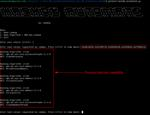
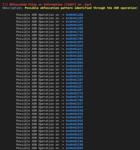
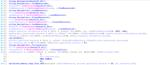
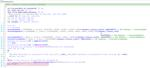
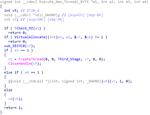
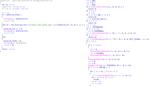
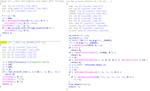
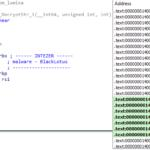
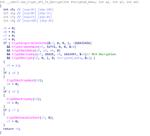
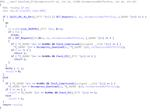
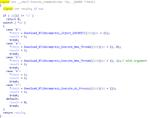
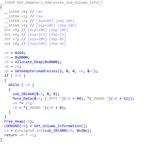
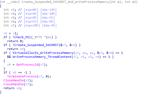
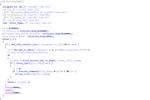
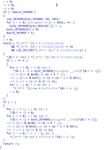
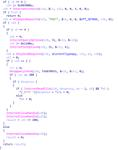
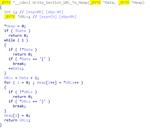
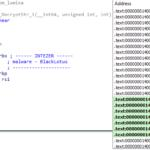
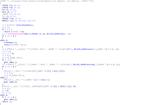
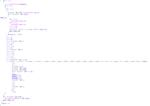
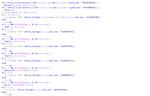
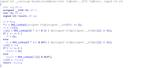
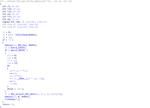
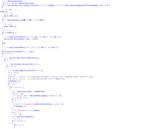
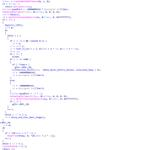
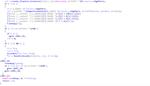
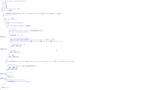
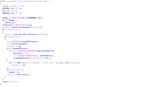
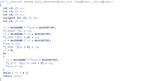
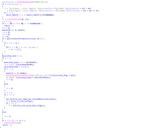
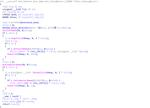
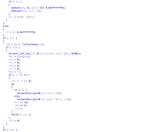
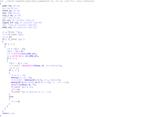
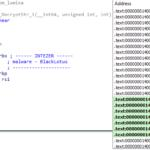
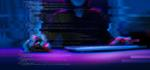
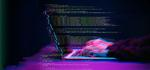
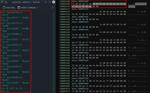
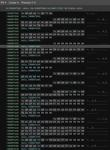
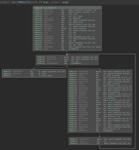
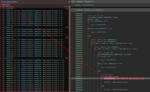
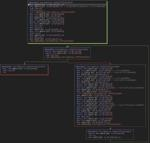
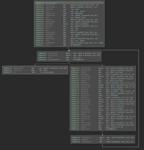
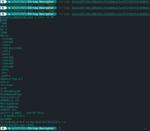
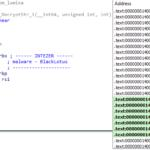
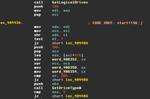
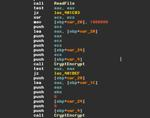
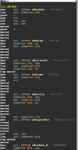
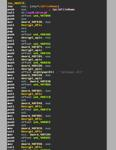
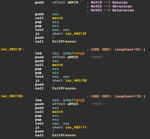
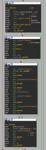
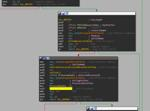
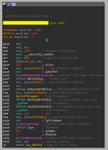
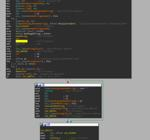
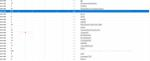
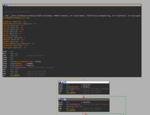
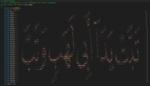
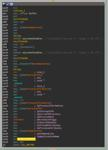
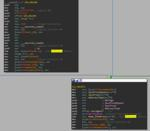
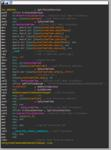
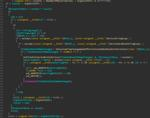
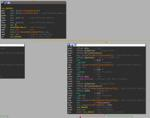
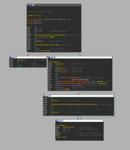
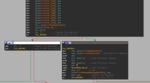
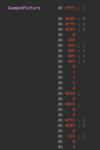
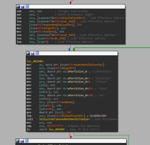
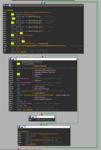
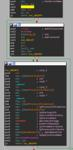
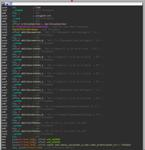
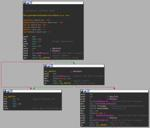
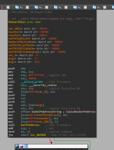
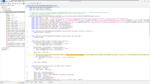
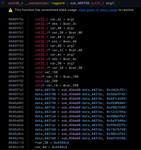
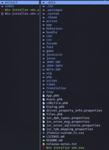
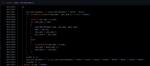
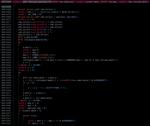
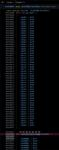
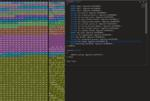
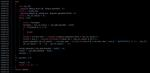
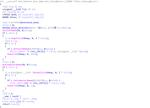
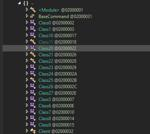
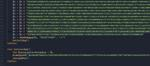
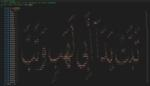
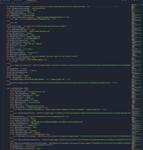
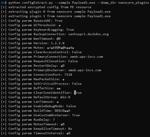
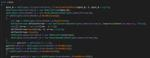
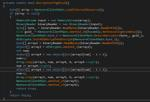
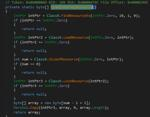
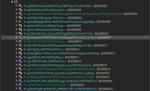
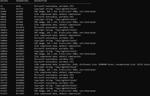
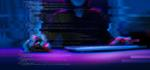
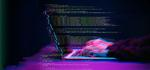
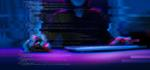
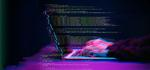
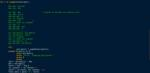
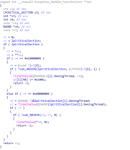
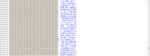
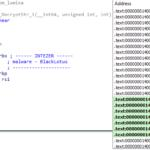
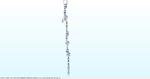
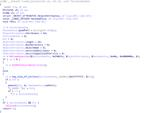
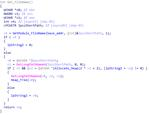
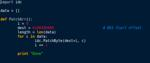
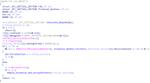
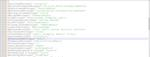
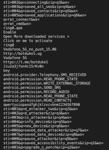
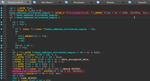
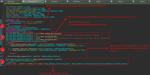
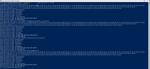
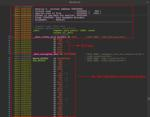
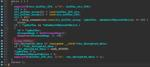
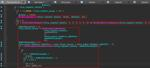
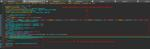
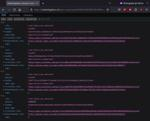
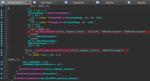
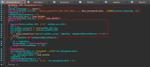
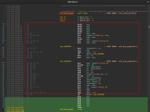
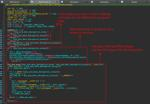
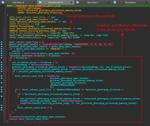
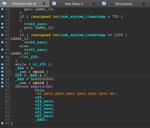
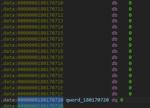
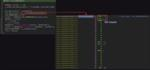
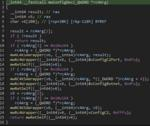
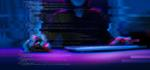
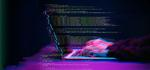
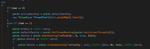
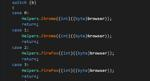
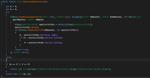
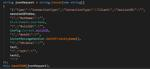
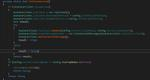
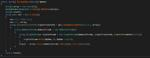
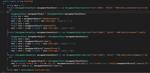
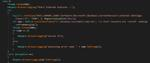
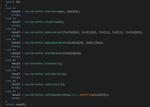
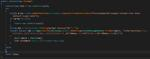
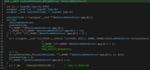
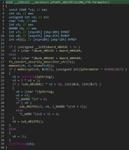
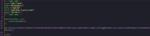
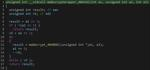
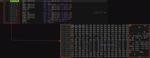
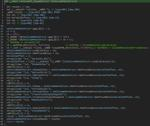
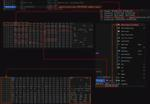
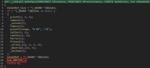
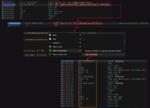
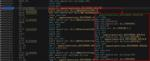
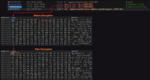
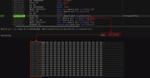
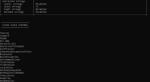
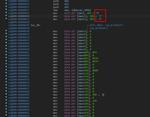
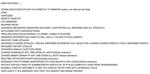
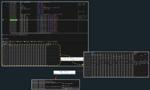
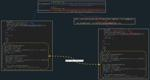
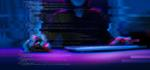
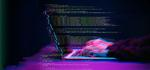
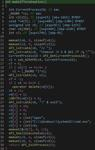
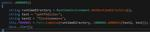
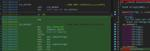
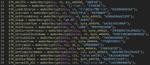
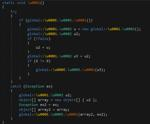
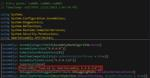
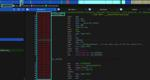
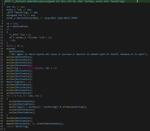
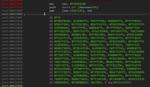
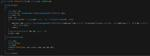
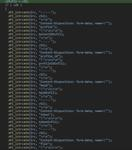
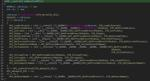
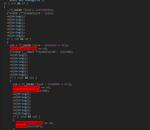
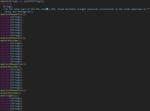
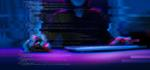
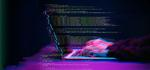
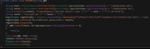
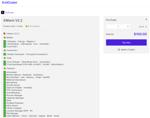
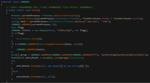
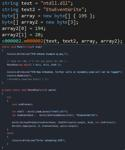
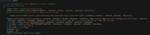
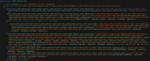
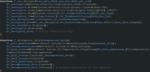
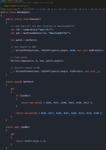
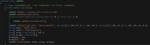
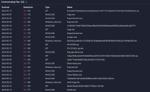
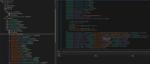
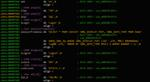
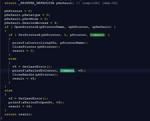
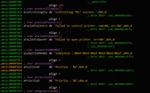
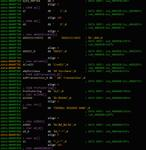
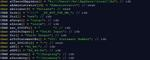
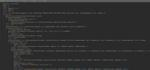
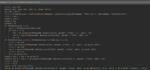
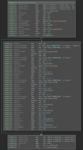
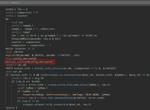
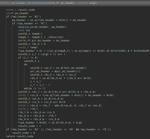
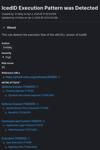
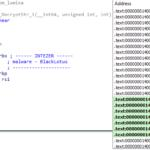
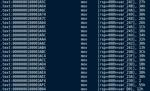
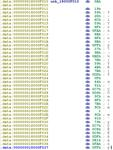
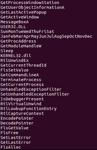
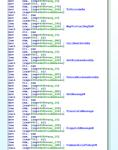
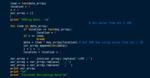
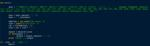
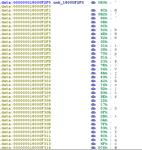
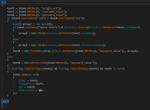
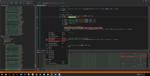
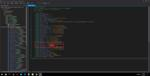
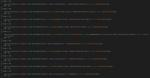
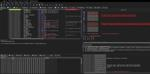
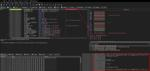
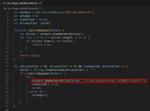
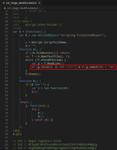
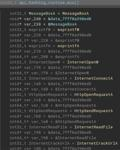
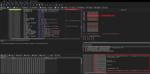
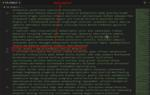
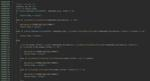
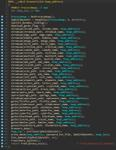
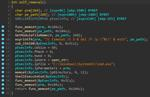
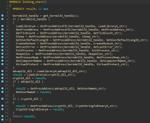
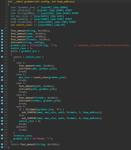
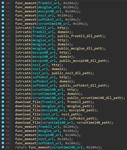
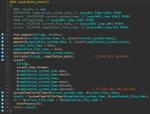
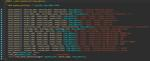
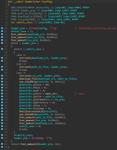
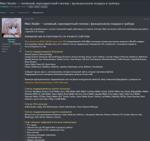
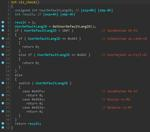
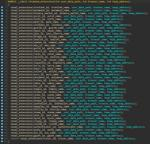
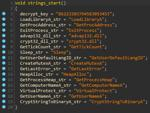

In [27]:
display_results(results_code)

/home/bartek/Kod/PD/pd_env/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



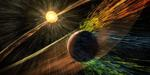
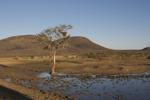
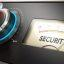
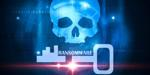
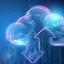
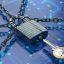
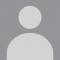
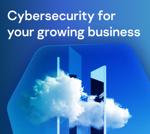
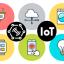
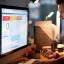
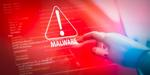
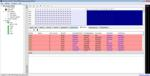
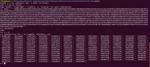
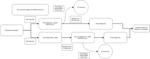
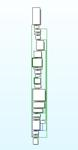
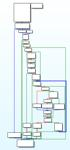
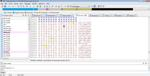
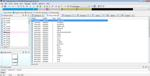
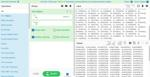
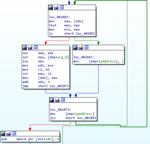
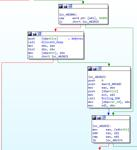
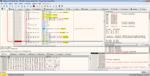
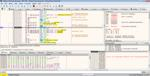
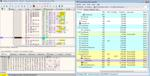
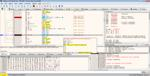
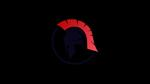
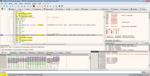
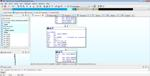
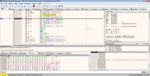
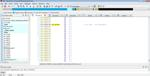
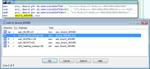
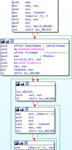
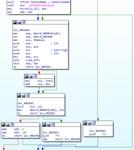
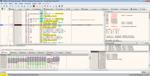
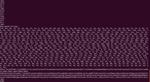
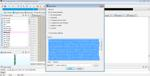
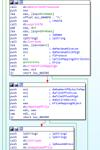
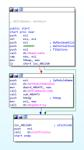
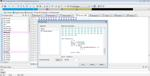
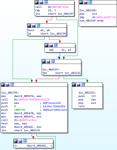
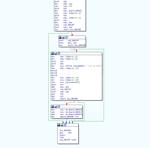
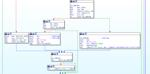
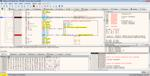
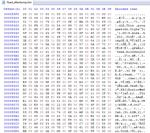
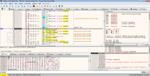
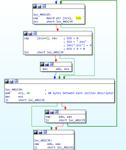
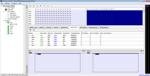
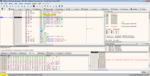
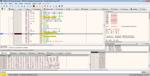
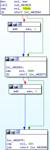
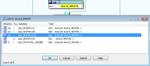
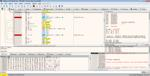
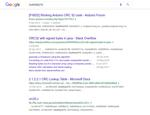
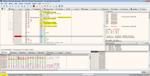
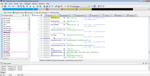
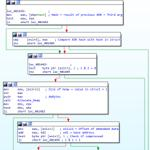
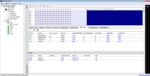
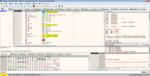
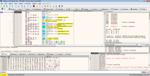
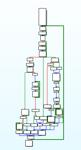
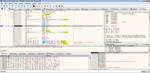
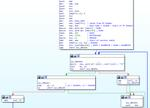
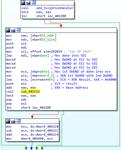
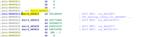
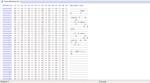
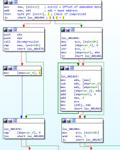
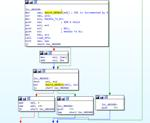
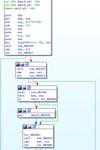
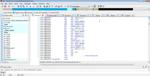
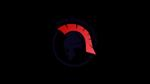
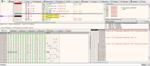
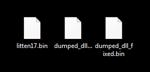
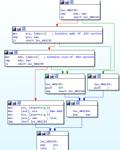
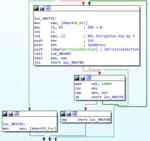
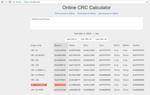
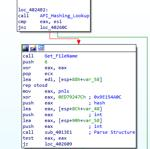
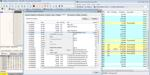
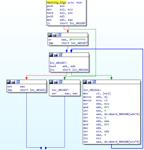
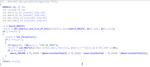
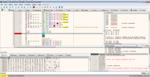
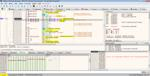
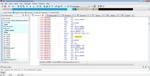
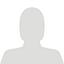
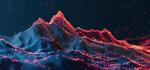
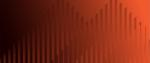
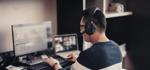
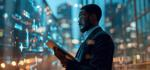
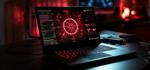
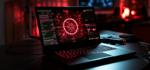
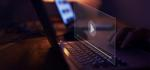
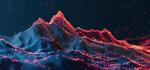
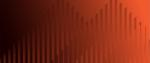
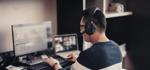
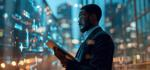
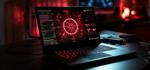
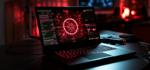
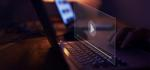
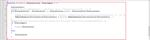
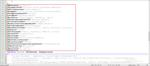
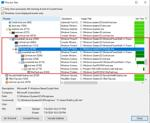
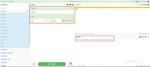
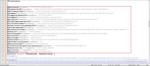
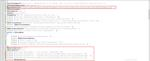
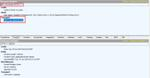
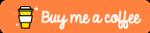
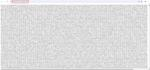
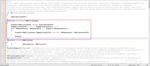
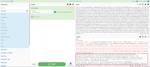
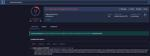
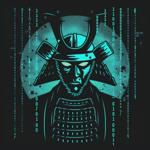
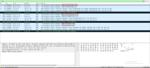
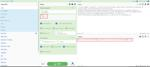
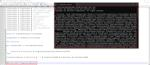
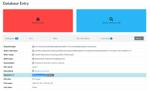
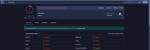
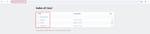
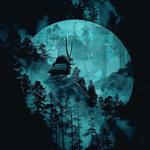
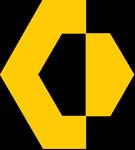
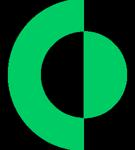
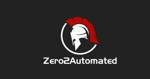
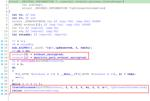
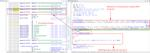
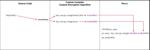
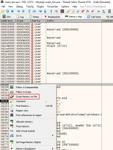
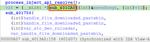
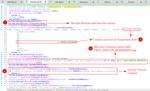
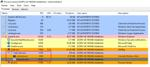
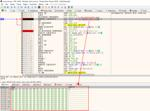
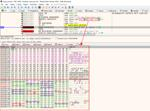
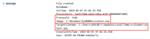
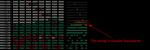
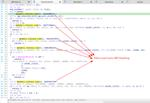
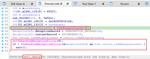
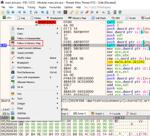
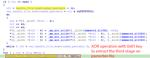
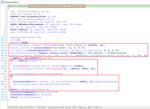
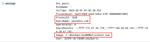
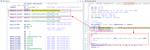
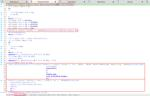
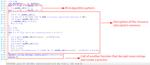
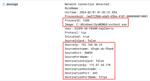
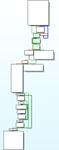
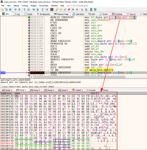
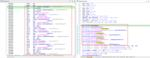
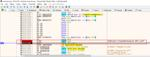
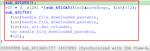
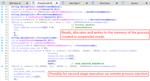
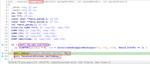
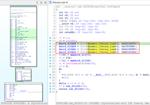
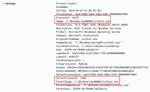
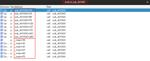
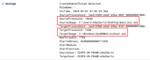
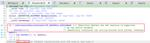
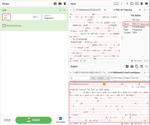
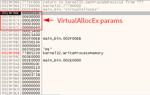
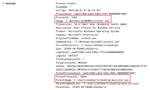
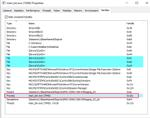
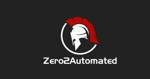
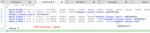
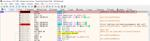
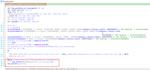
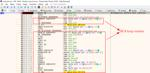
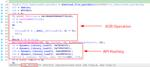
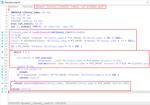
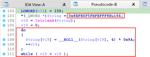
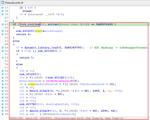
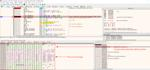
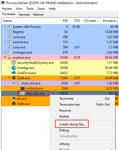
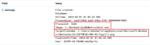
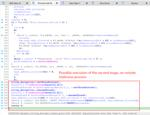
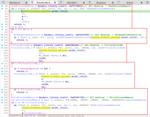
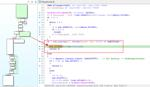
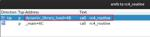
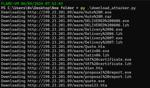
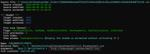
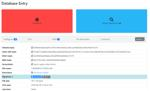
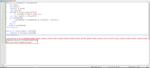
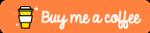
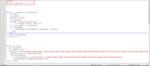
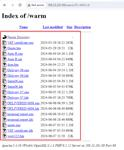
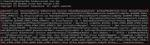
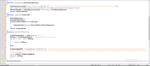
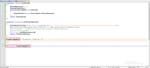
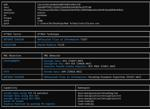
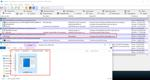
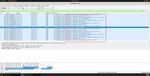
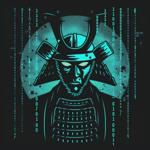
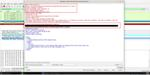
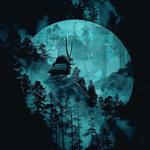
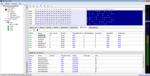
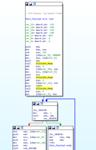
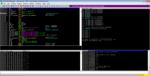
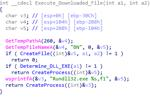
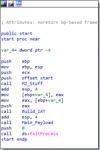
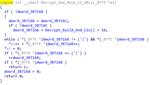
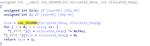
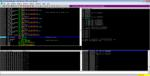
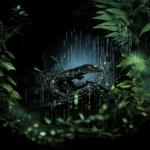
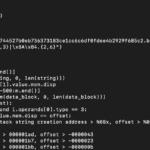
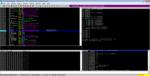
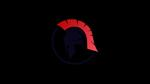
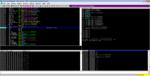
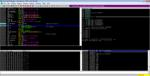
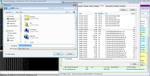
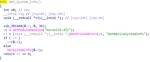
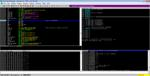
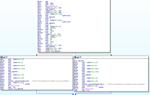
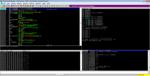
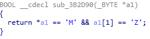
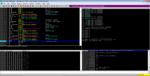
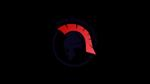
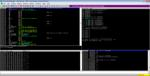
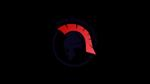
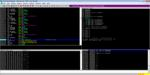
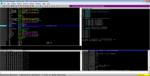
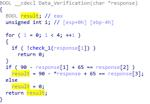
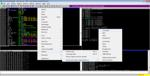
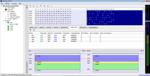
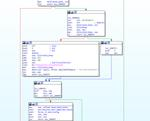
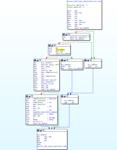
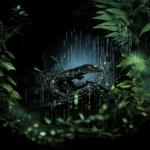
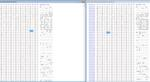
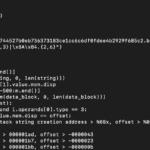
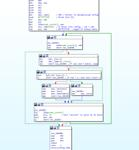
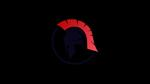
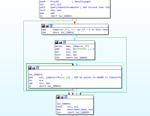
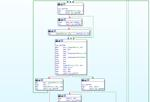
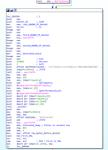
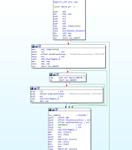
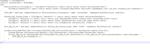
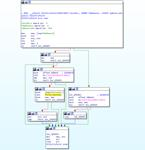
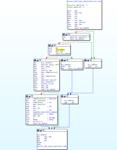
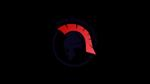
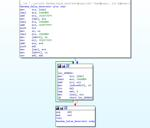
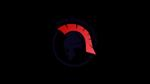
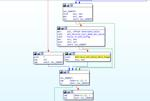
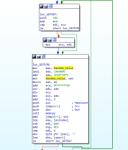
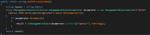
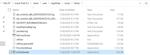
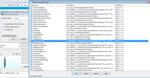
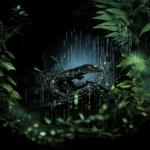
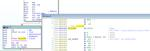
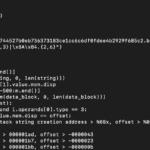
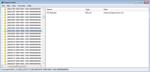
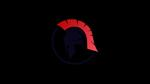
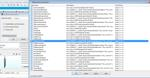
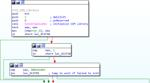
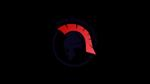
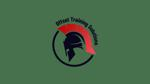
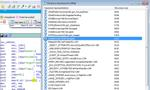
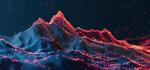
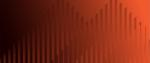
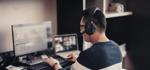
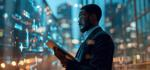
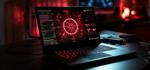
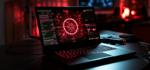
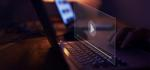
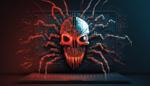
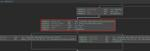
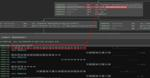
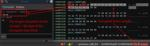
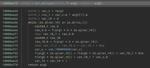
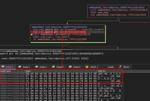
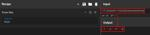
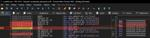
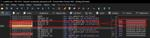
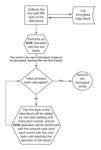
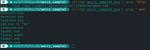
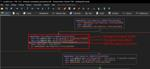
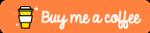
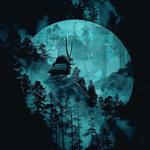
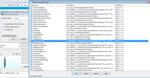
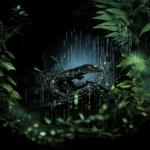
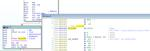
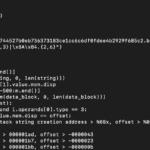
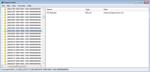
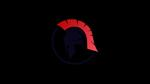
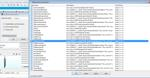
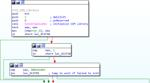
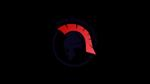
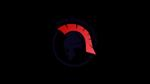
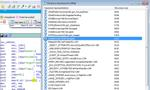
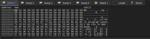
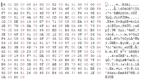
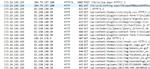
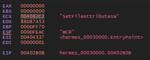
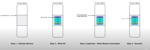
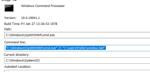
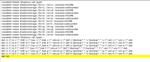
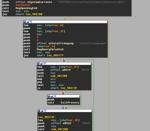
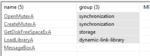
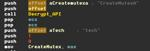
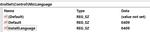
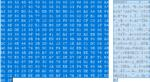
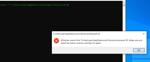
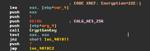
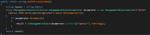
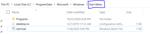
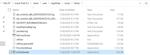
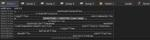
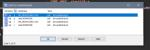
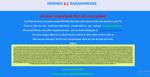
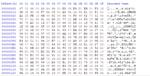
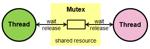
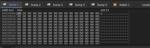
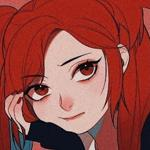
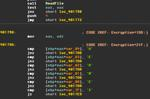
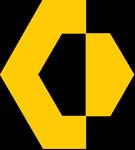
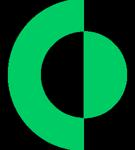
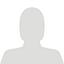
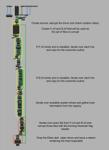
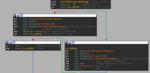
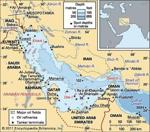
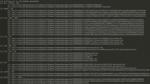
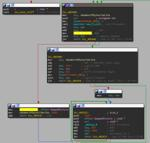
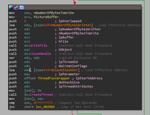
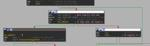
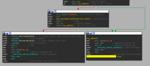
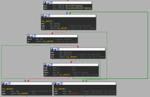
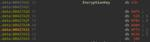
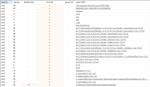
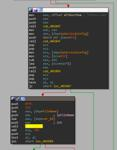
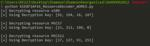
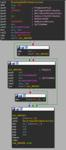
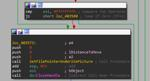
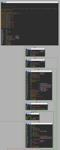
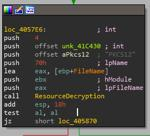
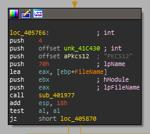
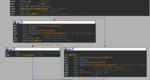
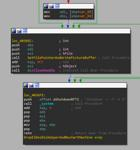
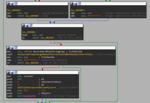
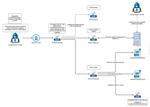
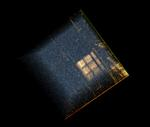
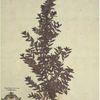
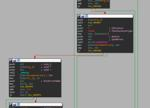
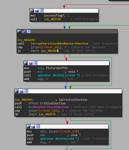
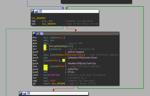
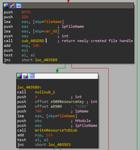
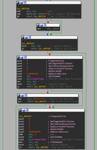
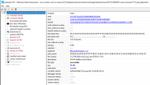
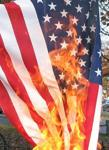
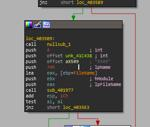
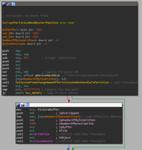
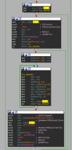
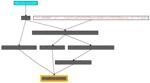
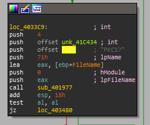
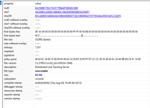
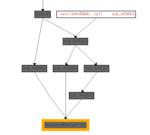
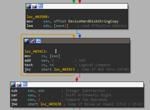
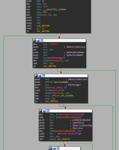
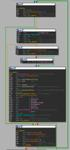
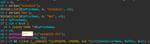
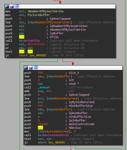
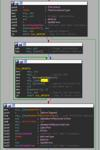
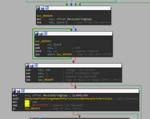
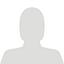
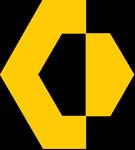
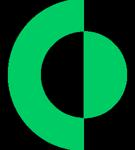
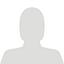
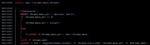
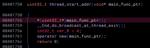
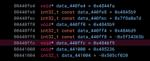
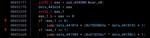
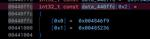
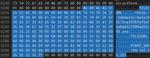
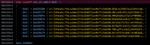
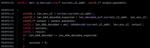
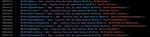
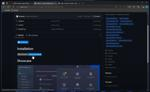
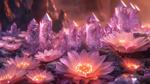
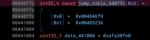
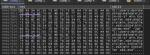
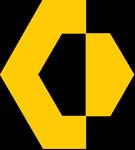
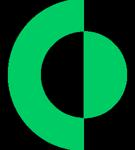
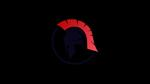
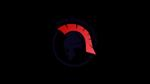
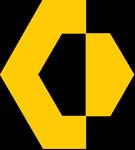
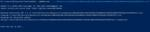
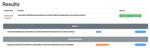
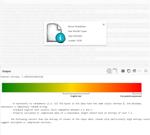
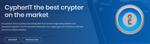
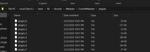
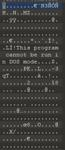
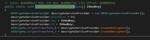
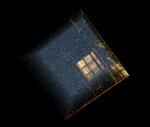
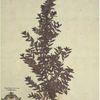
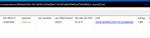
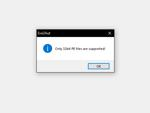
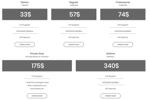
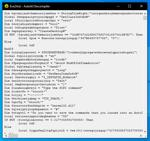
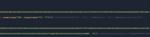
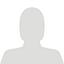
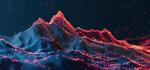
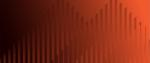
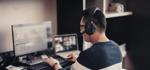
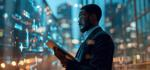
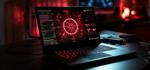
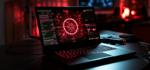
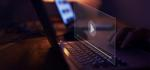
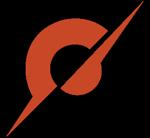
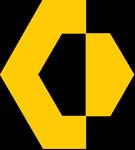
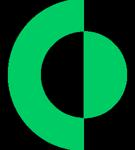
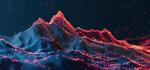
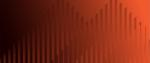
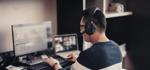
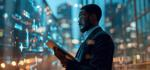
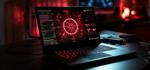
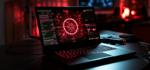
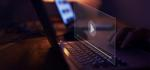
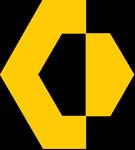
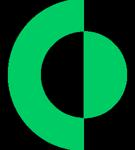
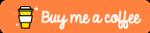
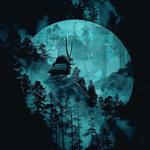
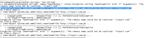
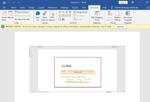
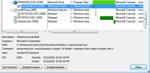
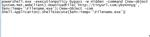
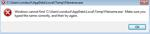
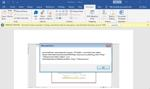
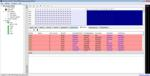
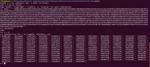
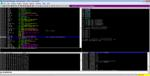
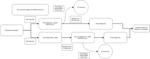
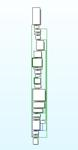
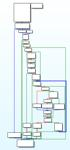
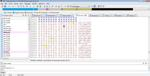
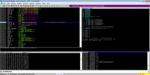
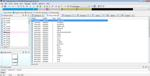
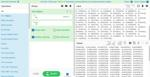
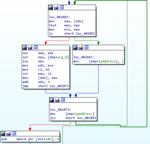
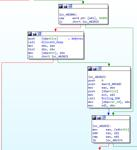
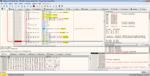
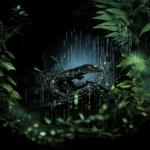
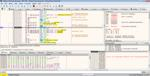
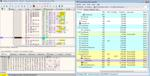
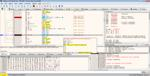
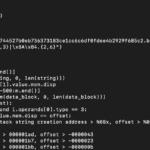
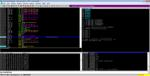
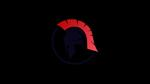
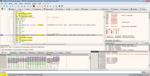
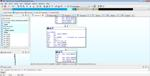
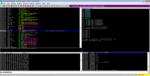
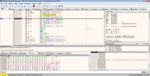
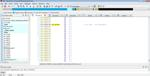
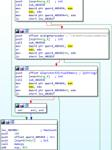
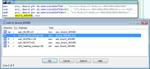
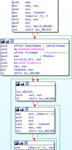
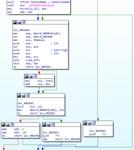
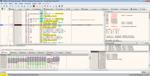
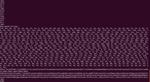
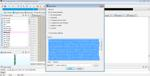
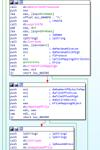
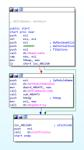
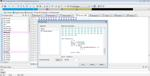
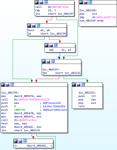
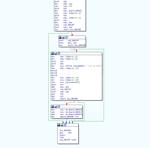
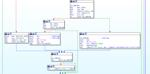
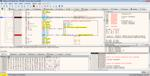
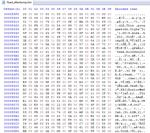
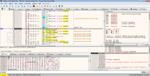
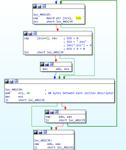
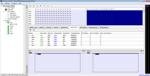
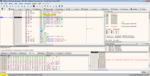
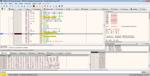
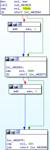
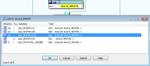
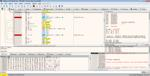
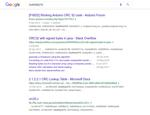
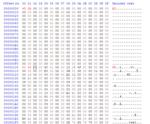
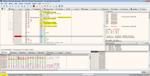
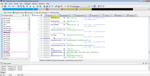
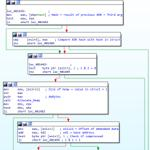
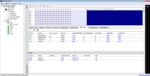
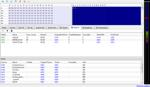
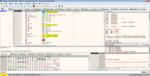
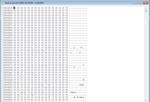
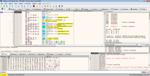
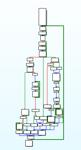
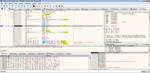
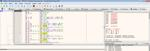
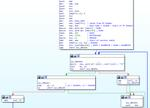
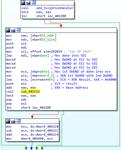
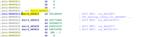
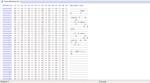
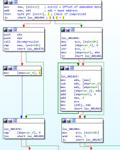
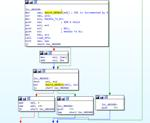
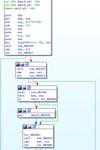
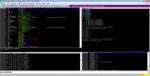
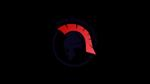
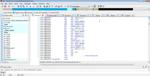
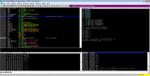
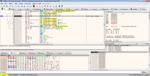
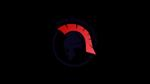
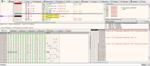
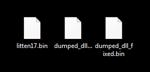
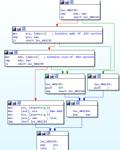
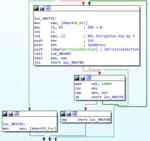
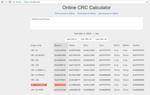
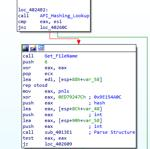
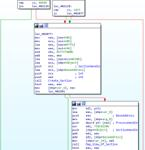
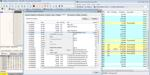
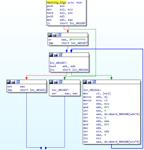
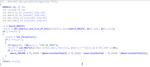
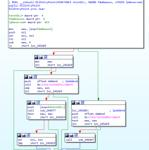
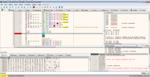
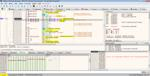
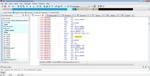
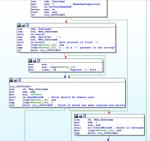
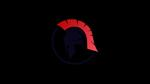
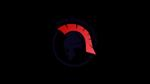
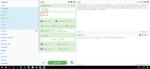
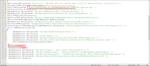
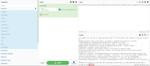
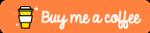
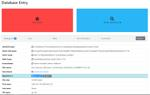
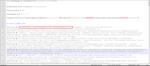
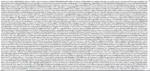
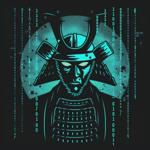
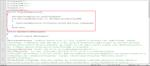
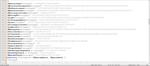
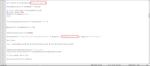
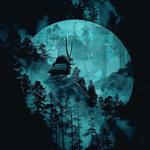
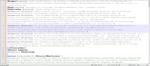
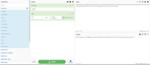
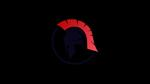
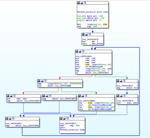
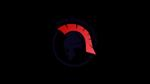
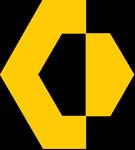
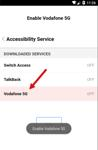
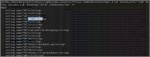
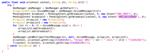
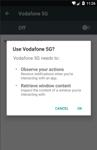
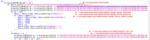
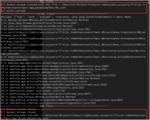
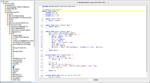
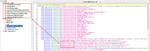
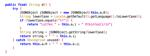
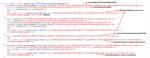
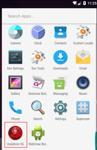
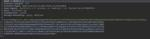
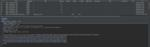
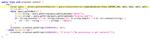
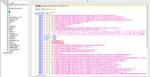
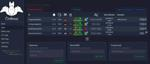
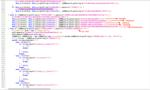
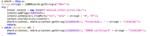
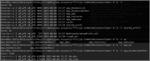
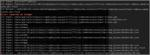
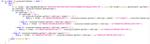
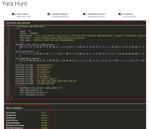
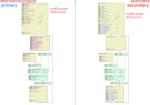
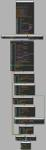
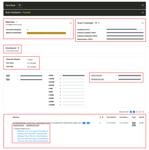
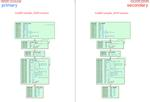
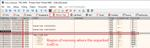
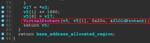
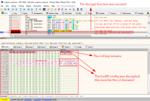
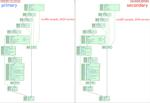
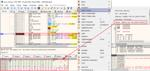
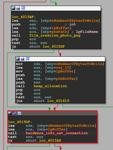
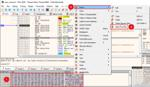
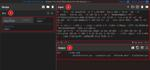
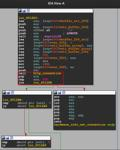
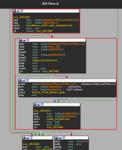
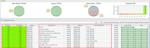
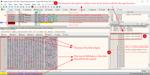
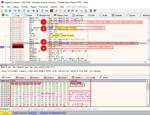
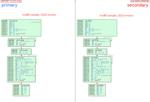
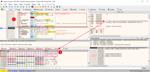
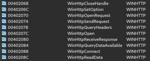
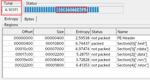
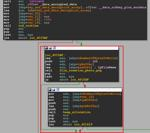
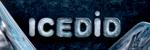
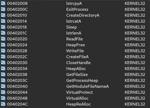
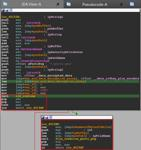
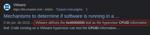
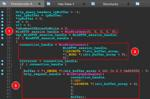
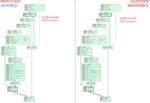
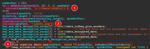
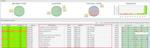
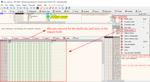
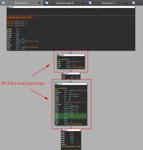
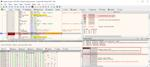
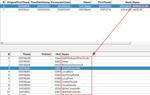
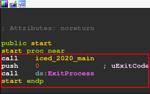
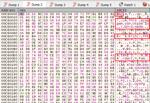
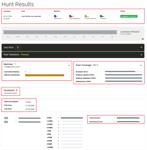
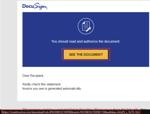
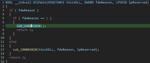
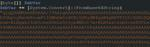
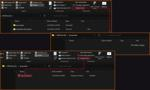
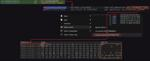
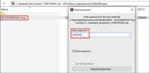
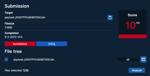
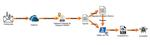
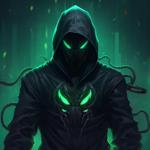
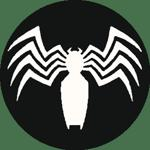
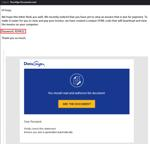
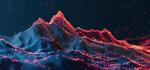
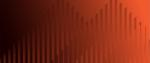
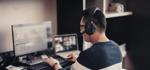
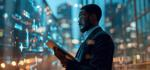
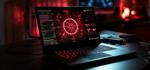
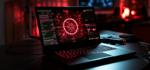
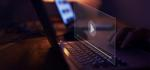
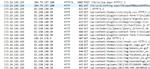
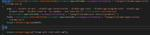
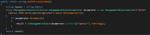
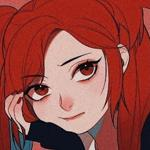
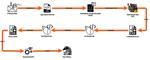
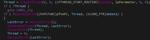
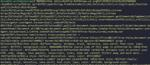
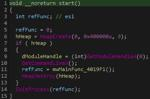
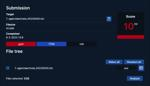
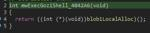
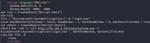
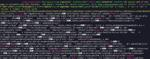
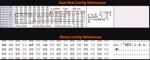
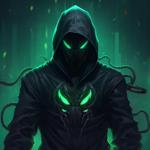
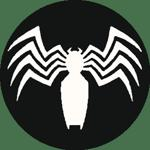
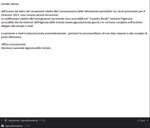
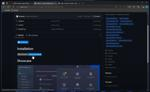
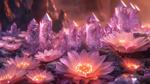
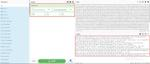
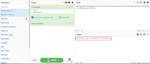
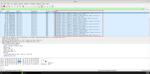
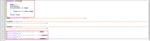
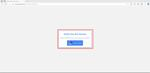
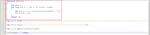
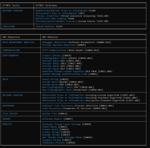
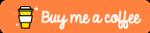
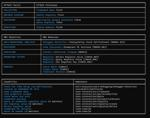
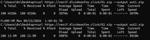
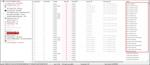
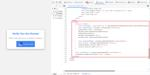
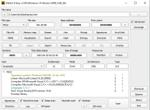
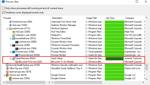
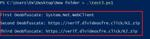
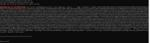
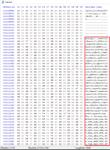
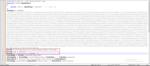
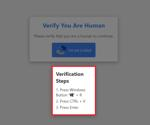
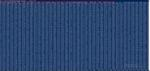
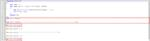
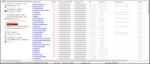
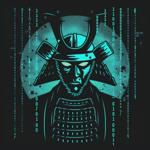
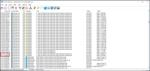
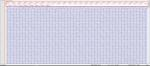
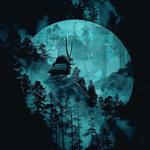
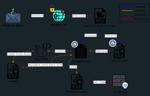
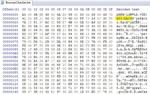
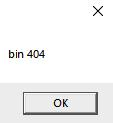
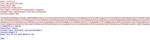
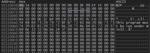
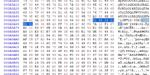
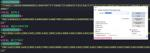
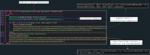
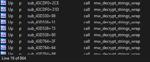
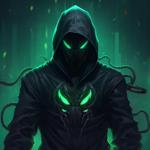
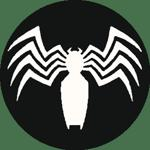
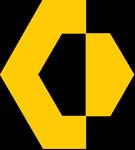
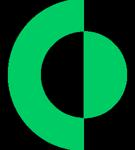
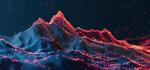
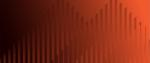
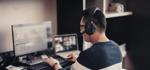
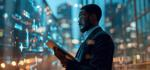
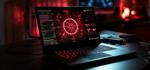
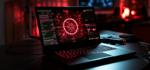
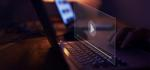
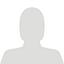
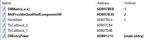
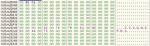
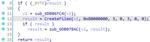
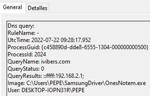
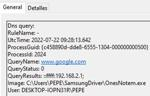
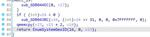
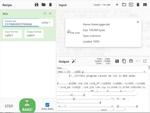
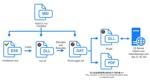
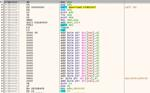
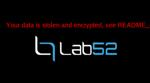
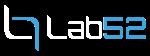
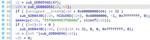
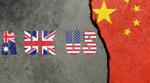
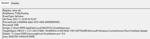
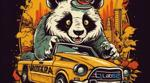
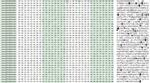
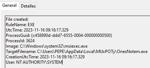
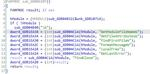
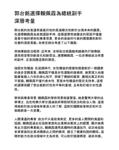
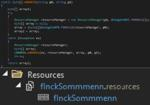
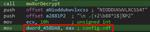
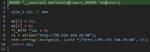
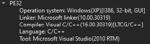
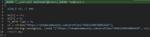
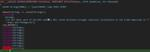
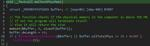
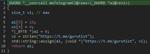
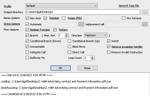
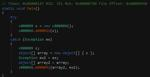
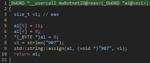
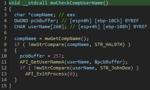
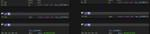
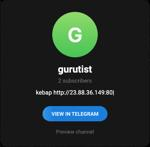
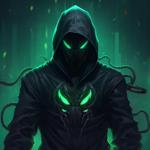
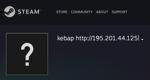
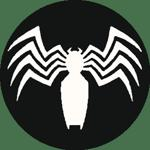
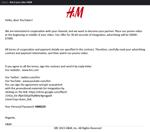
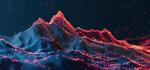
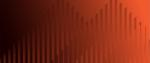
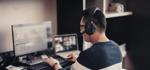
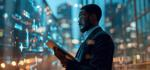
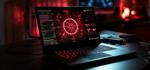
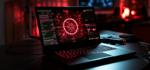
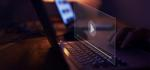
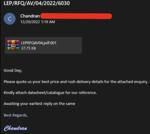
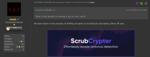
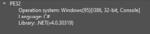
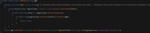
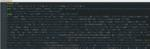
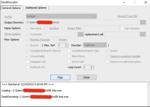
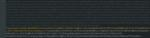
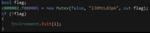
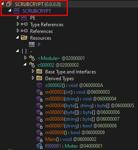
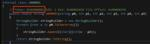
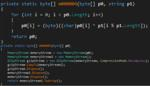
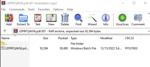
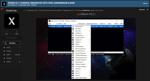
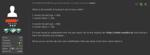
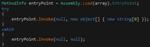
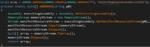
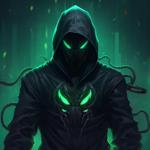
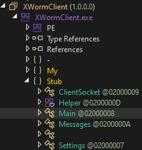
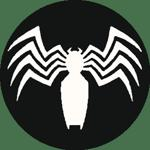
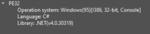
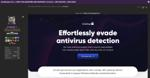
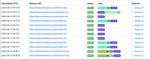
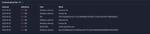
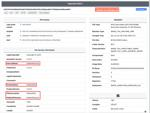
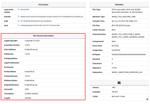
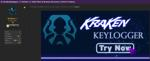
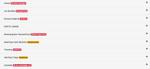
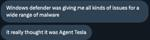
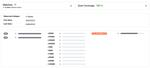
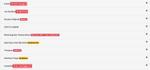
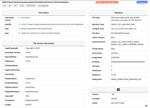
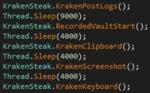
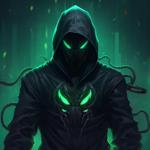
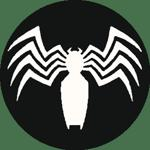
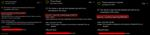
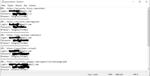
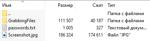
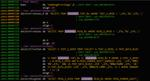
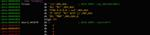
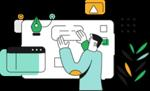
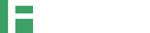
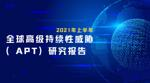
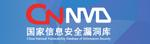
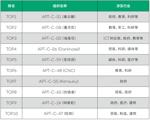
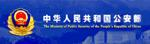
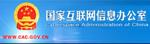
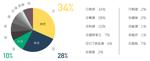
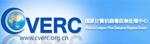
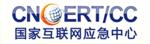
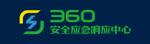
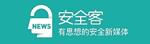
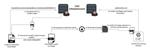
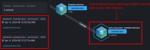
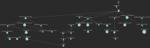
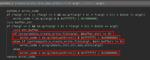
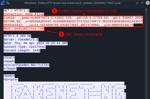
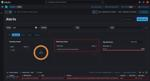
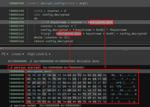
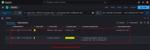
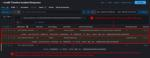
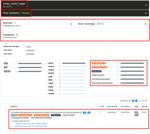
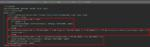
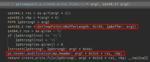
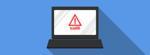
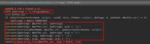
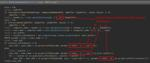
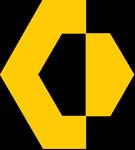
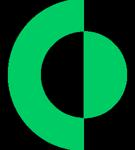
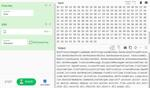
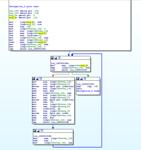
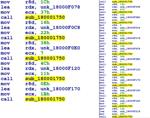
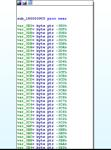
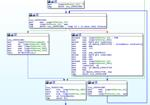
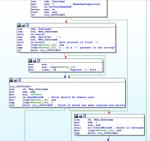
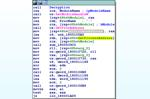
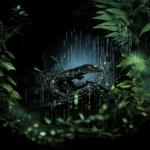
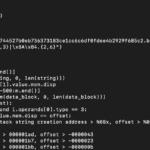
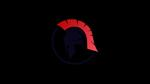
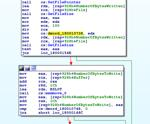
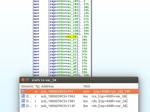
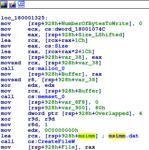
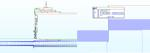
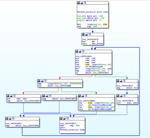
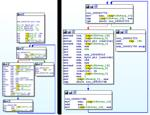
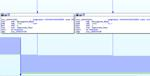
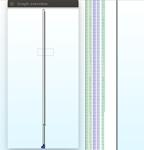
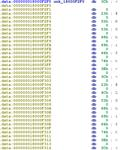
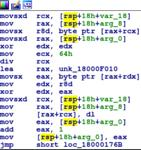
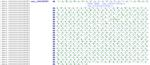
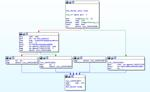
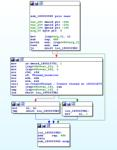
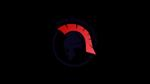
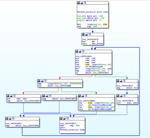
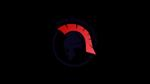
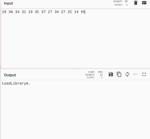
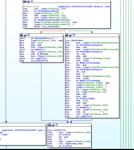
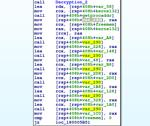
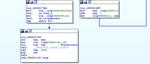
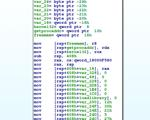
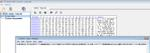
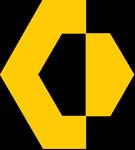
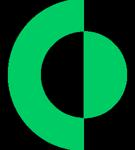
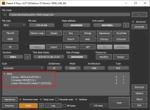
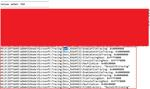
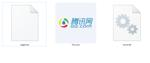
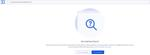
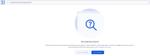
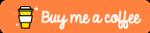
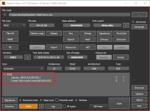
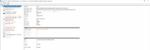
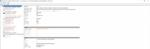
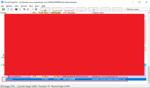
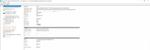
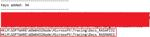
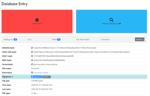
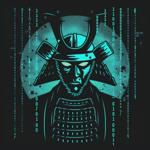
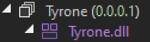
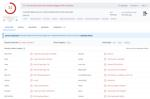
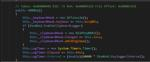
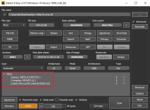
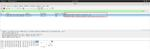
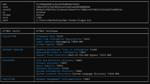
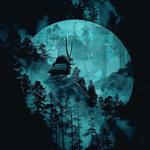
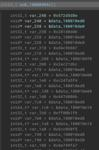
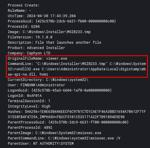
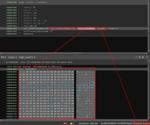
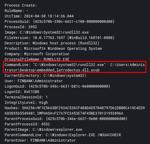
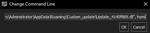
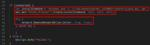
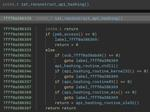
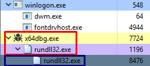
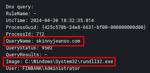
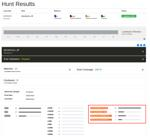
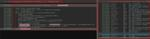
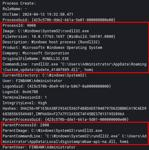
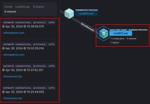
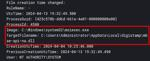
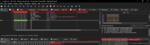
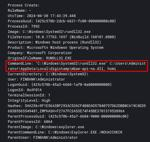
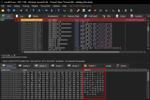
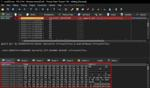
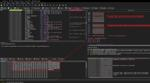
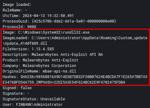
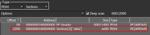
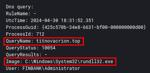
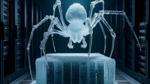
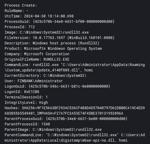
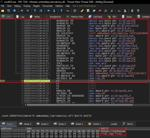
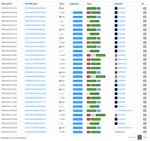
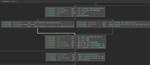
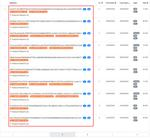
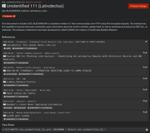
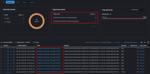
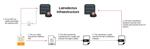
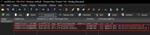
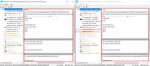
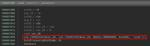
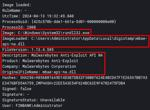
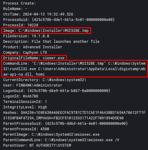
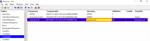
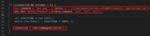
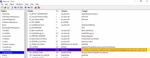
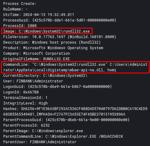
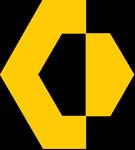
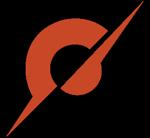
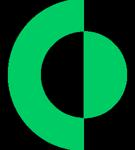
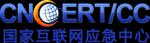
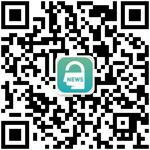
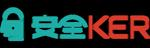
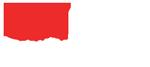
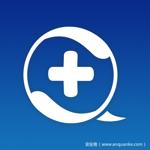
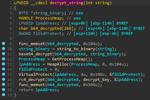
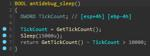
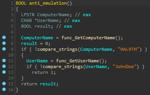

In [28]:
display_results(results_not_code)